In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from umap import UMAP

import seaborn as sns
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import transforms
from matplotlib.patches import Patch
import matplotlib.cm as cm

import bcg_utils as utils

%load_ext autoreload
%autoreload 1
%aimport misc
%aimport bcg_utils
%aimport bcg_colors

from bcg_colors import *

In [2]:
_ = utils.setup_plotting(style='ticks', context='notebook', font_scale=1, rc=RC_PAPER)

FIG_SIZE = (1.25, 1.25)
HEATMAP_SIZE = (0.3, 0.3)
CIRCLE_SIZE = 20
CIRCLE_LINE_WIDTH = 0.4
ALPHA = 0.8

SAVE_FIG = True
fig_dir = utils.make_dir('results', 'figures', 'FigureS1')

In [3]:
count_file = os.path.join(os.path.join(misc.DATA, "analysis"), "quantification.csv.gz")
counts = pd.read_csv(count_file, index_col='ID')
lib_size_df = pd.DataFrame(counts.sum().rename('libsize'))
lib_size_df = lib_size_df.loc[lib_size_df.index.str.contains('_PBMC_')]
lib_size_df.index = lib_size_df.index.str.replace('_ATAC_R1$', '')
lib_size_df.to_csv(os.path.join(os.path.join(misc.DATA, "DE"), "libsizes.csv.gz"))
lib_size_df.head()

,libsize
300BCG027_V1_PBMC,1970127
300BCG027_V2_PBMC,1925178
300BCG027_V3_PBMC,2338298
300BCG028_V1_PBMC,2546008
300BCG028_V2_PBMC,2740178


In [4]:
DANIELE_METADATA = os.path.join(misc.DATA, 'analysis', 'complete_metadata_last.csv')
df_lukas = misc.get_sample_annot()
df_daniele = pd.read_csv(DANIELE_METADATA, index_col='DEMUX:BIOSAMPLE')
df_daniele.index = df_daniele.index.str.replace('_ATAC_R1', '')
assert (df_daniele.loc[~df_daniele.index.isin(df_lukas.index), 'QC:PASS'] == False).all()
assert df_lukas.loc[~df_lukas.index.isin(df_daniele.index), 'QC:PASS'].isnull().all()
shared_idx = df_daniele.index.intersection(df_lukas.index)
df_lukas = df_lukas.loc[shared_idx]
df_daniele = df_daniele.loc[shared_idx]
for col in df_daniele.columns:
    if col in df_lukas:
        try:
            pd.testing.assert_series_equal(df_lukas[col], df_daniele[col], check_dtype=False)
        except AssertionError as e:
            print('error:', col)
pd.testing.assert_series_equal(df_lukas['QC:PASS'], df_daniele['QC:PASS'], check_dtype=False)

error: DEMUX:BARCODE
error: DEMUX:PF_NORMALIZED_MATCHES
error: DEMUX:DEMUX_NAME
error: DEMUX:BARCODE_NAME
error: DONOR:IC_DATE
error: DONOR:IC_TIME
error: DONOR:AGE
error: DONOR:IC_TIME_CAT


# Suppl. Tables

In [3]:
DROP_EXCLUDED_DONORS = True
SAVE_TABLES = True
if SAVE_TABLES:
    suppl_tables = misc.get_container_with_tables([COHORT_AND_STATS, FULL_REGION_ANNOT]) # 

In [4]:
suppl_df = misc.suppl_table_cohort(misc.get_sample_annot(), drop_excluded=DROP_EXCLUDED_DONORS,
                                   suppl_tables=suppl_tables, table_name=COHORT_AND_STATS, fig_n='1')
donor_idx = suppl_df.index.get_level_values('Donor').values
display(suppl_df.head())

All donors: 327
Donors with BCG: 325
Donors without exclusions: 323
Donors with PBMCs: 323


Age Sex        BMI Oral contraceptives  \
Donor     Time point                                           
300BCG001 d0           23   F  21.107266                True   
          d14          23   F  21.107266                True   
          d90          23   F  21.107266                True   
300BCG002 d0           20   F  24.391059               False   
          d14          20   F  24.391059               False   

                     Alcohol within last 24h  Scar size (d90)  \
Donor     Time point                                            
300BCG001 d0                           False              0.4   
          d14                          False              0.4   
          d90                          False              0.4   
300BCG002 d0                           False              0.5   
          d14                          False              0.5   

                      Scar size (d14) Vaccination date Vaccination time  \
Donor     Time point                                                      
300BCG001 d0                      NaN       2017-04-10         08:45:00   
          d14                     NaN       2017-04-10         08:45:00   
          d90                     NaN       2017-04-10         08:45:00   
300BCG002 d0                      NaN       2017-04-10         09:15:00   
          d14                     NaN       2017-04-10         09:15:00   

                     Evening vaccination  ... Mother pox vaccine  \
Donor     Time point                      ...                      
300BCG001 d0                       False  ...               True   
          d14                      False  ...               True   
          d90                      False  ...               True   
300BCG002 d0                       False  ...               True   
          d14                      False  ...               True   

                     Father BCG vaccine Father pox vaccine General happiness  \
Donor     Time point                                                           
300BCG001 d0                      False               True                 7   
          d14                     False               True                 7   
          d90                     False               True                 7   
300BCG002 d0                      False               True                 8   
          d14                     False               True                 8   

                     Mental health 3 weeks before vaccination  \
Donor     Time point                                            
300BCG001 d0                                                2   
          d14                                               2   
          d90                                               2   
300BCG002 d0                                                4   
          d14                                               4   

                     Stress 2 weeks before vaccination  \
Donor     Time point                                     
300BCG001 d0                                         2   
          d14                                        2   
          d90                                        2   
300BCG002 d0                                         3   
          d14                                        3   

                      Stress within last 24h  Sleep-hours per night  \
Donor     Time point                                                  
300BCG001 d0                               2                    8.0   
          d14                              3                    8.0   
          d90                              2                    8.0   
300BCG002 d0                               4                    8.0   
          d14                              4                    8.0   

                      Sleep quality 2 weeks before vaccination  \
Donor     Time point                                             
300BCG001 d0                                                

In [5]:
suppl_df = misc.suppl_table_immune_response_scores(misc.get_sample_annot(), suppl_tables=suppl_tables,
                                                   table_name=COHORT_AND_STATS, fig_n='7')
assert suppl_df.index.isin(donor_idx).all()
display(suppl_df.head())

,Trained immunity score,Adaptive immunity score
Donor,,
300BCG001,1.307473,3.056249
300BCG002,1.400219,2.832723
300BCG003,1.743895,8.434890
300BCG004,1.363099,1.717290
300BCG005,1.134946,3.305276


In [6]:
suppl_df = misc.suppl_table_atac_seq_stats(misc.get_sample_annot(), drop_excluded=DROP_EXCLUDED_DONORS,
                                           suppl_tables=suppl_tables, table_name=COHORT_AND_STATS, fig_n='S1')
assert suppl_df['Donor'].isin(donor_idx).all()
display(suppl_df.head())

All donors: 327
Donors with BCG: 325
Donors with (any) ATAC-seq: 299
Donors without exclusions: 297
nkcell 23 QC: 23
monocyte 26 QC: 26
PBMC 297 QC: 297
cd8t 19 QC: 19


,Donor,Visit,Cell type,Protocol,Flowcell,Batch ID,QC pass,PCR Cq,Filtered peaks,TSS enrichment,...,Trim-loss percentage,Trimmed percentage,Not-trimmed percentage,Uniquely-aligned percentage,Not-uniquely-aligned percentage,Not-aligned percentage,Duplicate percentage,MT-mapped reads,MT-duplicate percentage,Peaks
Sample ID,,,,,,,,,,,,,,,,,,,,,
300BCG027_d0_PBMC,300BCG027,d0,PBMC,ATAC,HLW2KBBXX,BCG_P01,True,11.55,18152,5.356290,...,8.952346,19.377736,71.669918,72.24,26.85,0.91,14.060065,428811,94.149870,18165
300BCG027_d14_PBMC,300BCG027,d14,PBMC,ATAC,HLW2KBBXX,BCG_P01,True,11.17,25252,6.882369,...,9.131767,16.666093,74.202140,72.88,26.16,0.96,14.640407,416766,94.115403,25262
300BCG027_d90_PBMC,300BCG027,d90,PBMC,ATAC,HLW2KBBXX,BCG_P01,True,14.42,38438,7.763221,...,8.720176,18.743638,72.536187,75.59,23.48,0.93,29.666565,369803,93.739099,38449
300BCG028_d0_PBMC,300BCG028,d0,PBMC,ATAC,HLW2KBBXX,BCG_P01,True,11.01,37887,7.639225,...,8.670801,21.372258,69.956941,72.24,26.90,0.86,19.100799,881951,96.871822,37899
300BCG028_d14_PBMC,300BCG028,d14,PBMC,ATAC,HLW2KBBXX,BCG_P01,True,12.59,34302,7.032809,...,8.952393,17.593600,73.454007,72.98,26.27,0.76,19.524274,784084,96.611460,34312


In [7]:
for sheet_name, which_pipeline, allow_nulls, only_filtered, celltypes, table_name, info in [
    ('filtered_consensus_regions', '', False, True, 'PBMC', COHORT_AND_STATS,
     f'Annotation of genomic regions in the filtered consensus PBMC region set used for all downstream analysis{misc.related_to_fig_str("S1")}.'),
    
    ('PBMC_regions', '', False, False, 'PBMC', FULL_REGION_ANNOT,
     f'Annotation of all genomic regions in the consensus PBMC region set{misc.related_to_fig_str("S1F-H")}.'),
    
    ('PBMC_monocyte_NK_CD8T_regions', '_ALL', True, False, ['PBMC', 'monocyte', 'nkcell', 'cd8t'], FULL_REGION_ANNOT,
     f'Annotation of all genomic regions in the consensus region set of PBMCS, monocytes, NK cells, and CD8+ T cells{misc.related_to_fig_str("S1I")}.')
]:
    if only_filtered:
        assert celltypes == 'PBMC' or celltypes == ['PBMC']
        peaks_df = pd.read_csv(os.path.join(misc.DATA, 'DE{}'.format(which_pipeline), 'peaks_filtered_PBMC.csv.gz'), index_col=0)
    else:
        peaks_df = pd.read_csv(os.path.join(misc.DATA, 'analysis', 'peaks_characterization{}.csv.gz'.format(which_pipeline)), index_col=0)
        peaks_df = peaks_df.loc[peaks_df['chr'].isin(['chr{}'.format(i) for i in range(1, 23)] + ['chrX', 'chrY'])]
    
    assert peaks_df['chr'].isin(['chr{}'.format(i) for i in range(1, 23)] + ['chrX', 'chrY']).all()
    suppl_df = misc.suppl_table_peaks(peaks_df, allow_nulls=allow_nulls, suppl_tables=suppl_tables, sheet_name=sheet_name, info=info,
                                      table_name=table_name, fig_n=None)
    print(suppl_df.shape)
    display(suppl_df.head())

(64065, 18)


,Region ID,Chromosome,Start,End,Length,Ensembl gene ID,Gene symbol,Genomic feature,Genomic feature (fine-grain),Feature anchor,Distance to anchor,Location relative to feature,Genomic location,Genomic location (fine-grain),Ensembl Regulatory Build feature ID,Ensembl Regulatory Build feature,Promoter mapping,Distal mapping
Region,,,,,,,,,,,,,,,,,,
chr1_9832_10510,CONS00000000000,chr1,9832,10510,678,ENSG00000243485.5,MIR1302-2HG,LncRNA,gene:lncRNA,start,19382,Upstream,Intergenic (≥ 10kb),intergenic,ENSR00000344264,CTCF binding site,NaN,NaN
chr1_180528_181792,CONS00000000002,chr1,180528,181792,1264,ENSG00000241860.7,AL627309.5,LncRNA,gene:lncRNA,start,7298,Downstream,Distal (< 10kb),distal,NaN,Unassigned,NaN,NaN
chr1_191093_192116,CONS00000000004,chr1,191093,192116,1023,ENSG00000241860.7,AL627309.5,LncRNA,gene:lncRNA,start,17742,Downstream,Intergenic (≥ 10kb),intergenic,NaN,Unassigned,NaN,NaN
chr1_629677_631001,CONS00000000010,chr1,629677,631001,1324,ENSG00000235146.2,AC114498.1,LncRNA,gene:lncRNA,start,42711,Upstream,Intergenic (≥ 10kb),intergenic,ENSR00000249784,CTCF binding site,NaN,NaN
chr1_633765_634673,CONS00000000013,chr1,633765,634673,908,ENSG00000235146.2,AC114498.1,LncRNA,gene:lncRNA,start,46591,Upstream,Intergenic (≥ 10kb),intergenic,ENSR00000918325,CTCF binding site,NaN,NaN


(228191, 18)


,Region ID,Chromosome,Start,End,Length,Ensembl gene ID,Gene symbol,Genomic feature,Genomic feature (fine-grain),Feature anchor,Distance to anchor,Location relative to feature,Genomic location,Genomic location (fine-grain),Ensembl Regulatory Build feature ID,Ensembl Regulatory Build feature,Promoter mapping,Distal mapping
Region,,,,,,,,,,,,,,,,,,
chr1_9832_10510,CONS00000000000,chr1,9832,10510,678,ENSG00000243485.5,MIR1302-2HG,LncRNA,gene:lncRNA,start,19382,Upstream,Intergenic (≥ 10kb),intergenic,ENSR00000344264,CTCF binding site,NaN,NaN
chr1_96333_96846,CONS00000000001,chr1,96333,96846,513,ENSG00000238009.6,AL627309.1,LncRNA,gene:lncRNA,end,7295,PeakInsideFeature,Gene body,gene_body,NaN,Unassigned,NaN,NaN
chr1_180528_181792,CONS00000000002,chr1,180528,181792,1264,ENSG00000241860.7,AL627309.5,LncRNA,gene:lncRNA,start,7298,Downstream,Distal (< 10kb),distal,NaN,Unassigned,NaN,NaN
chr1_186656_187157,CONS00000000003,chr1,186656,187157,501,ENSG00000241860.7,AL627309.5,LncRNA,gene:lncRNA,start,13044,Downstream,Intergenic (≥ 10kb),intergenic,ENSR00000344295,CTCF binding site,NaN,NaN
chr1_191093_192116,CONS00000000004,chr1,191093,192116,1023,ENSG00000241860.7,AL627309.5,LncRNA,gene:lncRNA,start,17742,Downstream,Intergenic (≥ 10kb),intergenic,NaN,Unassigned,NaN,NaN


/home/lfolkman/miniconda3/envs/BCG/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(265570, 18)


,Region ID,Chromosome,Start,End,Length,Ensembl gene ID,Gene symbol,Genomic feature,Genomic feature (fine-grain),Feature anchor,Distance to anchor,Location relative to feature,Genomic location,Genomic location (fine-grain),Ensembl Regulatory Build feature ID,Ensembl Regulatory Build feature,Promoter mapping,Distal mapping
Region,,,,,,,,,,,,,,,,,,
chr1_9832_10510,CONS00000000000,chr1,9832,10510,678,ENSG00000243485.5,MIR1302-2HG,LncRNA,gene:lncRNA,start,19382,Upstream,Intergenic (≥ 10kb),intergenic,ENSR00000344264,CTCF binding site,NaN,NaN
chr1_96333_96846,CONS00000000001,chr1,96333,96846,513,ENSG00000238009.6,AL627309.1,LncRNA,gene:lncRNA,end,7295,PeakInsideFeature,Gene body,gene_body,NaN,Unassigned,NaN,NaN
chr1_180528_181792,CONS00000000002,chr1,180528,181792,1264,ENSG00000241860.7,AL627309.5,LncRNA,gene:lncRNA,start,7298,Downstream,Distal (< 10kb),distal,NaN,Unassigned,NaN,NaN
chr1_183567_184068,CONS00000000003,chr1,183567,184068,501,ENSG00000241860.7,AL627309.5,LncRNA,gene:lncRNA,start,9955,Downstream,Distal (< 10kb),distal,NaN,Unassigned,NaN,NaN
chr1_186656_187157,CONS00000000004,chr1,186656,187157,501,ENSG00000241860.7,AL627309.5,LncRNA,gene:lncRNA,start,13044,Downstream,Intergenic (≥ 10kb),intergenic,ENSR00000344295,CTCF binding site,NaN,NaN


In [8]:
if SAVE_TABLES:
    infos, tables = misc.close_tables_and_save(suppl_tables)
    for table, df in zip(tables, infos):
        print(table)
        display(df)

S01_sample_annotation


,Contents
Sheet name,
300BCG_cohort_annotation,The 300BCG cohort sample-level annotation (rel...
immune_response_scores,Trained and adaptive immunity response scores ...
ATACseq_statistics,The ATAC-seq sample-level quality statistics (...
filtered_consensus_regions,Annotation of genomic regions in the filtered ...


Ext_S01.1_region_annotation


,Contents
Sheet name,
PBMC_regions,Annotation of all genomic regions in the conse...
PBMC_monocyte_NK_CD8T_regions,Annotation of all genomic regions in the conse...


In [9]:
misc.fix_font_for_suppl_tables(suppl_tables)

# Figures

In [3]:
df = pd.read_csv(os.path.join(misc.DATA, 'analysis', 'peaks_characterization.csv.gz'), index_col=0)
print('all consensus peaks:', len(df))

all consensus peaks: 228619


In [4]:
atac_df = []
for celltype in ['PBMC', 'cd8t_monocyte_nkcell']:
#     atac_df.append(misc.get_batch_corrected_counts(celltype).T)
    atac_df.append(misc.get_norm_counts(celltype).T)
    print(celltype, 'ATAC-seq:', atac_df[-1].shape)
    print(celltype, 'donors with at least 1 x ATAC-seq:', (atac_df[-1].index.str.split('_', expand=True).to_frame().groupby([0]).count()[1] >= 1).sum())
    print(celltype, 'donors with at least 2 x ATAC-seq:', (atac_df[-1].index.str.split('_', expand=True).to_frame().groupby([0]).count()[1] >= 2).sum())
    print(celltype, 'donors with at least 3 x ATAC-seq:', (atac_df[-1].index.str.split('_', expand=True).to_frame().groupby([0]).count()[1] >= 3).sum())
atac_df = pd.concat(atac_df, axis=0)
assert not atac_df.isnull().any().any()
print('all ATAC-seq:', atac_df.shape)
print('all donors with at least 1 x ATAC-seq:', (atac_df.index.str.split('_', expand=True).to_frame().groupby([0]).count()[1] >= 1).sum())

PBMC ATAC-seq: (784, 64065)
PBMC donors with at least 1 x ATAC-seq: 299
PBMC donors with at least 2 x ATAC-seq: 273
PBMC donors with at least 3 x ATAC-seq: 212
cd8t_monocyte_nkcell ATAC-seq: (194, 64065)
cd8t_monocyte_nkcell donors with at least 1 x ATAC-seq: 27
cd8t_monocyte_nkcell donors with at least 2 x ATAC-seq: 27
cd8t_monocyte_nkcell donors with at least 3 x ATAC-seq: 27
all ATAC-seq: (978, 64065)
all donors with at least 1 x ATAC-seq: 299


In [5]:
df = misc.get_sample_annot()
df.loc[(df['SAMPLE:VISIT'] == 'V1') & (df['QC:PASS'] == True)].groupby('SAMPLE:TISSUE')['QC:PASS'].count()

SAMPLE:TISSUE
PBMC        275
cd8t         19
monocyte     26
nkcell       23
Name: QC:PASS, dtype: int64

In [6]:
df = misc.get_sample_annot()

idx_all = df.loc[df['SAMPLE:TISSUE'].isin(['PBMC', 'cd8t', 'nkcell', 'monocyte'])
                 & df['SAMPLE:EXCLUSION'].isnull()].index
idx_all = idx_all.intersection(atac_df.index)

idx_PBMCs = df.loc[(df['SAMPLE:TISSUE'] == 'PBMC')
                   & df['SAMPLE:EXCLUSION'].isnull()].index
idx_PBMCs = idx_PBMCs.intersection(atac_df.index)

idx_all_PBMC_V1_sorted = df.loc[((df['SAMPLE:TISSUE'] == 'PBMC') |
                                 (df['SAMPLE:TISSUE'].isin(['cd8t', 'nkcell', 'monocyte']) & (df['SAMPLE:VISIT'] == 'V1')))
                                & df['SAMPLE:EXCLUSION'].isnull()].index
idx_all_PBMC_V1_sorted = idx_all_PBMC_V1_sorted.intersection(atac_df.index)

print('donors with ATAC-seq without exclusions:', len(set(df.loc[idx_all_PBMC_V1_sorted, 'SAMPLE:DONOR'])))
for celltype in ['PBMC', 'monocyte', 'nkcell', 'cd8t']:
    print(celltype, atac_df.loc[idx_all_PBMC_V1_sorted].index.str.endswith(celltype).sum())

donors with ATAC-seq without exclusions: 297
PBMC 780
monocyte 26
nkcell 23
cd8t 19


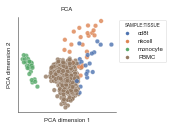

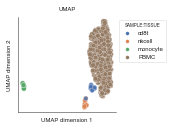

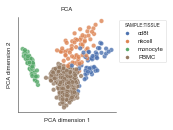

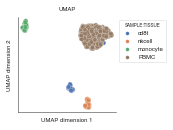

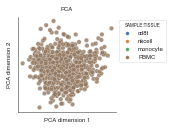

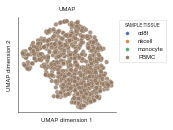

In [7]:
for idx, save_fig in [
    (idx_all_PBMC_V1_sorted, SAVE_FIG),
    (idx_all, False),
    (idx_PBMCs, False)
]:
#     shuffle = np.concatenate([np.random.RandomState(misc.RANDOM_STATE).permutation(np.arange(atac_df.index[atac_df.index.str.endswith('_PBMC')].shape[0], atac_df.shape[0])),
#                               np.arange(atac_df.index[atac_df.index.str.endswith('_PBMC')].shape[0])])
    shuffle = np.random.RandomState(misc.RANDOM_STATE).permutation(range(len(idx)))
    for method in ['PCA', 'UMAP']:
        if method == 'PCA':
            embedding = PCA(n_components=2, random_state=misc.RANDOM_STATE).fit_transform(
                StandardScaler().fit_transform(atac_df.loc[idx]))
        elif method == 'UMAP':
            embedding = UMAP(n_components=2, random_state=misc.RANDOM_STATE).fit_transform(
                StandardScaler().fit_transform(atac_df.loc[idx]))
        else:
            raise ValueError

        embedding = pd.DataFrame(data=embedding,
                                 index=atac_df.loc[idx].index, columns=['Dimension {}'.format(i + 1) for i in range(embedding.shape[1])])
        for palette, column in [
            ({'SAMPLE:TISSUE': [BLUE, ORANGE, GREEN, BROWN]}, 'SAMPLE:TISSUE'),
        ]:
            _ = misc.pca_analysis(
                    categorical_labels=[column],
                    pca_df=embedding.iloc[shuffle],
                    annot_df=df.loc[idx].iloc[shuffle],
                    title_prefix=None, force_title=method,
                    fig_dir=fig_dir,
                    fig_prefix='{}.atac.{}.'.format(method, column),
                    random_state=misc.RANDOM_STATE,
                    scatter_kwargs=dict(linewidth=0.25, legends='brief', n_dims=2, palettes=palette, orders='random',
                                        num_legend_fmt='.1f', alpha=ALPHA, s=CIRCLE_SIZE,
                                        xlabel='{} dimension'.format(method), ylabel='{} dimension'.format(method),
                                        show_xticks=False, show_yticks=False, figsize=(1.75, 1.75),
                                        hue_orders={'SAMPLE:TISSUE': ['cd8t', 'nkcell', 'monocyte', 'PBMC']}, rasterized=not (save_fig and method == 'PCA')),
                    plot_variance_explained=False, plot_scatter=True, plot_assoc_heatmap=False, verbose=False,
                    show=True, save_fig=save_fig, dpi=DPI)

# Supplementary Figures

In [3]:
CELLTYPES = ['PBMC', 'nkcell', 'cd8t', 'monocyte']
overlap_df = pd.DataFrame(index=['nkcell', 'cd8t', 'monocyte'], columns=['all_regions', 'filtered_regions'])
for suffix in ['ALL']: # 'ALL_binary' 'ALL_VISITS'
    df = pd.read_csv(os.path.join(misc.DATA, 'analysis', 'quantification_binary_{}.csv.gz'.format('ALL' if suffix == 'ALL_binary' else suffix)), index_col=0).T
    all_regions, filtered_regions = {}, {}
    print(suffix, 'all peaks', df.shape[1], '\n')
    for celltype in CELLTYPES:
        x = df.loc[df.index.str.contains('_{}_'.format(celltype))]
        all_regions[celltype] = set(x.columns[(x != 0).any(axis=0)])
        del x
        filtered_regions[celltype] = set(pd.read_csv(os.path.join(misc.DATA, 'DE_{}'.format(suffix), 'peaks_{}.csv'.format(celltype)), index_col=0, header=None).index)

        print('{}: all_regions {} | filtered_regions {}'.format(
            celltype,
            len(all_regions[celltype]),
            len(filtered_regions[celltype])
        ))
    print('')    

    for celltype in CELLTYPES:
        if celltype != 'PBMC':
            overlap_df.loc[celltype, 'all_regions'] = len(all_regions['PBMC'].intersection(all_regions[celltype])) / len(all_regions[celltype])
            overlap_df.loc[celltype, 'filtered_regions'] = len(filtered_regions['PBMC'].intersection(filtered_regions[celltype])) / len(filtered_regions[celltype])
            print('{}: all_regions {:.2f} | filtered_regions {:.2f}'.format(
                celltype, overlap_df.loc[celltype, 'all_regions'],overlap_df.loc[celltype, 'filtered_regions']
            ))
    print('\n------\n')

ALL all peaks 266032 

PBMC: all_regions 226638 | filtered_regions 67261
nkcell: all_regions 141482 | filtered_regions 69578
cd8t: all_regions 106922 | filtered_regions 45222
monocyte: all_regions 129485 | filtered_regions 85930

nkcell: all_regions 0.85 | filtered_regions 0.79
cd8t: all_regions 0.93 | filtered_regions 0.98
monocyte: all_regions 0.83 | filtered_regions 0.66

------



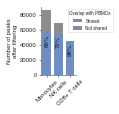

In [4]:
x = {'monocyte': 'Monocytes', 'nkcell': 'NK cells', 'cd8t': 'CD8+ T cells'}
y_in_PBMC = [len(filtered_regions[celltype].intersection(filtered_regions['PBMC'])) for celltype in x]
y_not_in_PBMC = [len(filtered_regions[celltype].difference(filtered_regions['PBMC'])) for celltype in x]
width = 0.75

fig, ax = plt.subplots(figsize=(FIG_SIZE[0] / 2, FIG_SIZE[1]))
bars = ax.bar(x.keys(), y_in_PBMC, width, label='Shared', color=BLUE, lw=0, alpha=ALPHA)
ax.bar(x.keys(), y_not_in_PBMC, width, bottom=y_in_PBMC, label='Not shared', color=GRAY, lw=0)

for celltype, bar in zip(x, bars):
    height = bar.get_height()
    ax.annotate('{}%'.format(round(overlap_df.loc[celltype, 'filtered_regions'] * 100)),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0.4, -14),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', color='k', rotation=90)

ax.set_xticklabels([x[k] for k in x], rotation=45)
ax.set_ylabel('Number of peaks\nafter filtering')
ax.legend(bbox_to_anchor=(0.7, 1), title='Overlap with PBMCs', fontsize=SMALL_FONT)
sns.despine()
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'celltypes_PBMC_peak_overlap.svg'))
plt.show()

In [39]:
thresholds = {
    'RUN:TSS_ENRICHMENT': 4.5,
    'RUN:FILTERED_PEAKS': 5000
}

In [54]:
df = misc.get_sample_annot()
df = df.loc[((df['SAMPLE:TISSUE'] == 'PBMC') | (df['SAMPLE:VISIT'] == 'V1')) & (df['SAMPLE:TISSUE'] != 'neutrophil')]

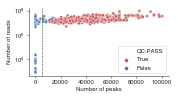

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(FIG_SIZE[0] * 2, FIG_SIZE[1]))
ax = sns.scatterplot(data=df.sort_values('QC:PASS', ascending=False),
                     x='RUN:FILTERED_PEAKS', y='RUN:FASTQC_TOTAL_PASS_FILTER_READS', hue='QC:PASS',
                     alpha=ALPHA, palette=[RED, BLUE], linewidth=CIRCLE_LINE_WIDTH)
ax.set_yscale('log')
ax.set_ylabel('Number of reads')
ax.set_xlabel('Number of peaks')
ax.axvline(thresholds['RUN:FILTERED_PEAKS'], ls='--', c=rcParams['axes.edgecolor'], lw=rcParams['axes.linewidth'])
sns.despine()
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'QC_reads_peaks.pdf'))

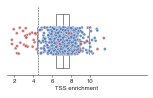

In [56]:
data = pd.concat([df[['RUN:TSS_ENRICHMENT', 'QC:PASS']], pd.Series(['RUN:TSS_ENRICHMENT'] * df.shape[0], index=df.index)], axis=1)
data = data.loc[np.isfinite(data['RUN:TSS_ENRICHMENT'])].sort_values('QC:PASS', ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(FIG_SIZE[0] * 2, FIG_SIZE[1]))
ax = sns.boxplot(data=data, y=0, x='RUN:TSS_ENRICHMENT', fliersize=0, orient='h')
plt.setp(ax.artists, edgecolor='k', facecolor='w', lw=0.5)
plt.setp(ax.lines, color='k', lw=0.5)
ax = sns.stripplot(data=data, y=0, x='RUN:TSS_ENRICHMENT', hue='QC:PASS', palette=[RED, BLUE], linewidth=CIRCLE_LINE_WIDTH, edgecolor='white',
                   size=3, alpha=ALPHA, jitter=0.2, orient='h')
ax.legend(bbox_to_anchor=(1, 1), markerscale=0.5, title='QC').set_visible(False)
ax.set_xlim((1.24, 16))
ax.set_xticks([2, 4, 6, 8, 10])
ax.set_yticks([])
ax.set_ylabel(None)
ax.set_xlabel('TSS enrichment')
ax.axvline(thresholds['RUN:TSS_ENRICHMENT'], ls='--', c=rcParams['axes.edgecolor'], lw=rcParams['axes.linewidth'])
sns.despine(left=True)
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'QC_tssEnr.pdf'))

In [57]:
df.sort_values('QC:PASS', ascending=False)

,CM:ADA_P00813,CM:AXIN1_O15169,CM:Beta.NGF_P01138,CM:CASP.8_Q14790,CM:CCL11_P51671,CM:CCL19_Q99731,CM:CCL20_P78556,CM:CCL23_P55773,CM:CCL25_O15444,CM:CCL28_Q9NRJ3,...,thm.innate_nonspecific_24h_IL10_IL1ra_V3,thm.innate_nonspecific_24h_IL10_IL1ra_V3_FC1.2_responder,thm.innate_nonspecific_24h_V3,thm.innate_nonspecific_24h_V3_FC1.2_responder,thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3,thm.innate_nonspecific_24h_wo_LAC_IL10_IL1ra_V3_FC1.2_responder,thm.innate_nonspecific_24h_wo_LAC_V3,thm.innate_nonspecific_24h_wo_LAC_V3_FC1.2_responder,thm.lactate_V3,thm.lactate_V3_FC1.2_responder
SAMPLE:ID,,,,,,,,,,,,,,,,,,,,,
300BCG027_V1_PBMC,3.94011,3.64521,1.65876,1.79732,7.36555,9.25085,5.09211,9.27536,6.35927,1.99854,...,0.965859,R,0.561627,R,0.473541,R,0.538008,R,0.408774,R
300BCG234_V1_nkcell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.035929,N,0.652303,R,0.729350,R,0.652303,R,0.083123,N
300BCG232_V1_nkcell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
300BCG232_V2_PBMC,3.44008,3.16534,1.79061,1.74271,6.45565,8.89202,5.17484,10.96504,5.24313,2.27886,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
300BCG233_V1_PBMC,3.52583,5.51708,1.33115,2.45858,7.01134,9.19357,5.51707,10.03300,5.81484,1.50252,...,1.050513,R,0.436129,R,0.353553,R,0.430993,R,-0.082837,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300BCG310_V2_PBMC,3.97731,4.97911,1.38437,2.03654,6.79271,9.49137,5.63388,9.65406,5.89076,1.78815,...,-0.702606,N,0.635246,R,0.698635,R,0.635246,R,-0.174261,N
300BCG311_V2_PBMC,3.76440,4.72158,1.54310,2.93454,6.75660,9.22693,5.97716,9.88172,5.24240,1.71835,...,1.259943,R,0.667739,R,0.587122,R,0.667739,R,-0.309937,N
300BCG312_V2_PBMC,3.46942,5.52562,1.59047,2.77084,7.09736,9.16406,5.80512,10.68335,6.50840,1.98564,...,-0.214386,N,0.460258,R,0.505678,R,0.438225,R,0.125940,N


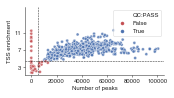

,RUN:TSS_ENRICHMENT,RUN:FILTERED_PEAKS
SAMPLE:ID,,
300BCG147_V1_PBMC,0.000000,0.0
300BCG125_V2_PBMC,0.000000,0.0
300BCG164_V3_PBMC,0.000000,0.0
300BCG094_V1_PBMC,1.732353,785.0
300BCG202_V1_PBMC,1.748127,1.0
...,...,...
300BCG310_V2_PBMC,NaN,NaN
300BCG311_V2_PBMC,NaN,NaN
300BCG312_V2_PBMC,NaN,NaN


In [46]:
df.loc[df['RUN:TSS_ENRICHMENT'] == np.inf, 'RUN:TSS_ENRICHMENT'] = 0
fig, ax = plt.subplots(1, 1, figsize=(FIG_SIZE[0] * 2, FIG_SIZE[1]))
ax = sns.scatterplot(data=df.sort_values('QC:PASS', ascending=False),
                     x='RUN:FILTERED_PEAKS', y='RUN:TSS_ENRICHMENT', hue='QC:PASS',
                     alpha=ALPHA, palette=[RED, BLUE], hue_order=[False, True], linewidth=CIRCLE_LINE_WIDTH)
ax.set_ylabel('TSS enrichment')
ax.set_xlabel('Number of peaks')
ax.axvline(thresholds['RUN:FILTERED_PEAKS'], ls='--', c=rcParams['axes.edgecolor'], lw=rcParams['axes.linewidth'])
ax.axhline(thresholds['RUN:TSS_ENRICHMENT'], ls='--', c=rcParams['axes.edgecolor'], lw=rcParams['axes.linewidth'])
ax.set_ylim((1.24, 17))
ax.set_yticks([3, 7, 11])
sns.despine()
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'QC_tssEnr_peak.svg'))
plt.show()
df[['RUN:TSS_ENRICHMENT', 'RUN:FILTERED_PEAKS']].sort_values('RUN:TSS_ENRICHMENT')

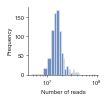

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(FIG_SIZE[0], FIG_SIZE[1]))
ax = sns.distplot(df.loc[df['QC:PASS'] == True, 'RUN:FASTQC_TOTAL_PASS_FILTER_READS'], hist_kws=dict(color=BLUE, alpha=ALPHA), kde=False)
ax.set_xscale('log')
ax.set_xlabel('Number of reads')
ax.set_ylabel('Frequency')
sns.despine()
utils.savefig(os.path.join(fig_dir, 'QC_reads.svg'))

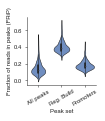

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(FIG_SIZE[0], FIG_SIZE[1]))
ax = sns.violinplot(data=df.loc[df['QC:PASS'], ['RUN:FRIP', 'RUN:ORACLE_FRIP', 'QC:PROMOTER_FRIP']].rename(
    dict({'RUN:FRIP': 'All peaks', 'RUN:ORACLE_FRIP': 'Reg. Build', 'QC:PROMOTER_FRIP': 'Promoters'}), axis=1).stack().reset_index(),
                    x='level_1', y=0, palette=['#708ec0', '#708ec0', '#708ec0'], linewidth=0.5, edgecolor='k', saturation=1)
for c in ax.collections:
    c.set_edgecolor('k')
for c in ax.get_children()[6:12]:
    c.set_color('k')
ax.set_xlabel('Peak set')
ax.set_ylabel('Fraction of reads in peaks (FRiP)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
sns.despine()
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'FRIP.svg'))

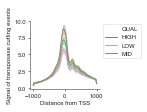

In [24]:
tss_upper=df.loc[df['QC:PASS'],'RUN:TSS_ENRICHMENT'].mean()+df.loc[df['QC:PASS'],'RUN:TSS_ENRICHMENT'].std()
tss_lower=df.loc[df['QC:PASS'],'RUN:TSS_ENRICHMENT'].mean()-df.loc[df['QC:PASS'],'RUN:TSS_ENRICHMENT'].std()
df['DEMUX:BIOSAMPLE'] = df.index
seed=10
selected_up=df.loc[df['QC:PASS'] & (df['RUN:TSS_ENRICHMENT']>tss_upper),'DEMUX:BIOSAMPLE']
selected_dn=df.loc[df['QC:PASS'] & (df['RUN:TSS_ENRICHMENT']<tss_lower),'DEMUX:BIOSAMPLE']
selected_mid=df.loc[df['QC:PASS'] & (df['RUN:TSS_ENRICHMENT']>=tss_lower) & (df['RUN:TSS_ENRICHMENT']<=tss_upper),'DEMUX:BIOSAMPLE']
selected=selected_up.append(selected_dn).append(selected_mid)

results=None
for sample in selected:
#     tss_file=os.path.join("/scratch/lab_bsf/projects/BSA_0322_BCG_FINAL","pipeline_run","results",sample,"{}_TSS.csv".format(sample))
    tss_file=os.path.join(misc.DATA, 'TSS_enrichment', '{}_ATAC_R1_TSS.csv'.format(sample))
    if (results is None):
        results=pd.read_csv(tss_file,names=['base',sample],skiprows=1).set_index('base')
    else:
        results=results.join(pd.read_csv(tss_file,names=['base',sample],skiprows=1).set_index('base'))
        
to_plot=results.reset_index().melt(id_vars='base')
to_plot['QUAL']='MID'
to_plot.loc[to_plot['variable'].isin(selected_up),'QUAL']='HIGH'
to_plot.loc[to_plot['variable'].isin(selected_dn),'QUAL']='LOW'

fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax=sns.lineplot(x='base', y='value', hue='QUAL', ci='sd', data=to_plot, palette=[BROWN, PINK, GREEN], err_kws=dict(alpha=0.4), linewidth=0.75)
# ax.set_xlim((-1000,1000))
ax.set_ylabel('Signal of transposase cutting events')
ax.set_xlabel('Distance from TSS')
ax.set_ylim((ax.get_ylim()[0], max(10, ax.get_ylim()[1])))
ax.legend(bbox_to_anchor=(1, 1))
sns.despine()
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'TSS_enrichment_plot.svg'))

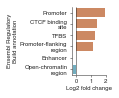

In [25]:
enrichment_results = pd.read_csv(os.path.join(misc.DATA, "analysis", "QC_characterization_enrichment.csv"),index_col='element_type')
to_plot_gencode=enrichment_results.loc[['TSS','TSS_proximal','gene_body','distal','intergenic'],['peaks(%)','LFC']]
to_plot_gencode=to_plot_gencode.sort_values(by='LFC',ascending=False).T
to_plot_regulatory=enrichment_results.loc[['promoter', 'CTCF_binding_site','TF_binding_site', 'promoter_flanking_region','enhancer','open_chromatin_region'],['peaks(%)','LFC']]
to_plot_regulatory=to_plot_regulatory.sort_values(by='LFC',ascending=False).T

fig, ax = plt.subplots(1, 1, figsize=(FIG_SIZE[0] * 0.5, FIG_SIZE[1]))
ax = sns.barplot(
    data=to_plot_regulatory.rename(dict(promoter='Promoter', enhancer='Enhancer',
                               CTCF_binding_site='CTCF binding\nsite', TF_binding_site='TFBS',
                               promoter_flanking_region='Promoter-flanking\nregion', open_chromatin_region='Open-chromatin\nregion'), axis=1).loc[['LFC'],:],
    ci=None,
    lw=0,
    edgecolor='black',
    orient='h',
    palette=[ORANGE, ORANGE, ORANGE, ORANGE, CYAN, CYAN]
)
ax.set_ylabel('Ensembl Regulatory\nBuild annotation')
ax.set_xlabel('Log2 fold change')
ax.set_xticks([0, 1, 2])
ax.axvline(0, c=rcParams['axes.edgecolor'], lw=rcParams['axes.linewidth'])
sns.despine()
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'reg_build_annot.svg'))

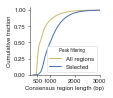

In [26]:
base_character = pd.read_csv(os.path.join(misc.DATA, "analysis", "peaks_characterization.csv.gz"), index_col='peak_id')
length=base_character['length']
q=0.99
quantile = np.quantile(length,q=[q])[0]
median = np.quantile(length,q=[0.5])[0]

fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax = sns.kdeplot(length, cumulative=True, legend=False, color=YELLOW, label='All regions')
ax.set_xticks([500, 1000, 2000, 3000])
ax.set_xlim(200, 3000)

base_character = pd.read_csv(misc.PEAK_ANNOT_ALL_FN, index_col=0)
length=base_character['length']
q=0.99
quantile = np.quantile(length,q=[q])[0]
median = np.quantile(length,q=[0.5])[0]

ax = sns.kdeplot(length, cumulative=True, legend=False, color=BLUE, label='Selected')
ax.set_xticks([500, 1000, 2000, 3000])
ax.set_xlim(200, 3000)
ax.set_xlabel('Consensus region length (bp)')
ax.set_ylabel('Cumulative fraction')
ax.legend(title='Peak filtering')
sns.despine()
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'cum_region_length.svg'))

In [27]:
analysis_folder = os.path.join(misc.DATA, "analysis")
sample_annotations_file = os.path.join(analysis_folder, "complete_metadata.csv")
peaks_annotations_file = os.path.join(analysis_folder, "peaks_characterization.csv.gz")
count_file = os.path.join(analysis_folder, "quantification.csv.gz")

sample_annotations = pd.read_csv(sample_annotations_file, index_col='DEMUX:BIOSAMPLE')
print('sample_annotations', sample_annotations.shape)
sample_annotations = sample_annotations[sample_annotations['QC:PASS']]
print('sample_annotations (QC:PASS)', sample_annotations.shape)

peaks_annotations = pd.read_csv(peaks_annotations_file, index_col='peak_id')
print('peaks_annotations', peaks_annotations.shape)

chrom = peaks_annotations['chr'].isin(['chr{}'.format(i) for i in range(1, 23)])
peaks_in_selected_chromosomes = peaks_annotations[chrom]
print('selected chromosomes:', sorted(set(peaks_in_selected_chromosomes['chr'])))
print('peaks_in_selected_chromosomes', peaks_in_selected_chromosomes.shape)

counts = pd.read_csv(count_file, index_col='ID').loc[peaks_in_selected_chromosomes.index, sample_annotations.index]

sample_annotations (1095, 81)
sample_annotations (QC:PASS) (978, 81)
peaks_annotations (228619, 13)
selected chromosomes: ['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9']
peaks_in_selected_chromosomes (222001, 13)


In [35]:
filtered_peaks = pd.read_csv(misc.PEAK_ANNOT_ALL_FN, index_col=0).index
df = misc.get_sample_annot()
df = df.loc[((df['SAMPLE:TISSUE'] == 'PBMC') | (df['SAMPLE:VISIT'] == 'V1')) & (df['SAMPLE:TISSUE'] != 'neutrophil') & df['QC:PASS']]
df.index = df.index + '_ATAC_R1'

In [29]:
counts = counts.loc[:, df.index]
counts = utils.tpm(counts, transcript_len=1, norm_factors=1, log=True, pseudocount=0.5, libsize_psuedocount=0, samples_as_rows=False)

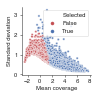

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=FIG_SIZE)
ax = sns.scatterplot(x=counts.mean(axis=1), y=counts.std(axis=1),
                     hue=pd.Series(counts.index.isin(filtered_peaks), index=counts.index, name='Selected'),
                     palette=[RED, BLUE], alpha=ALPHA, linewidth=CIRCLE_LINE_WIDTH, s=5, rasterized=RASTER)
ax.set_xlabel('Mean coverage')
ax.set_ylabel('Standard deviation')
ax.set_xticks([-2, 0, 2, 4, 6, 8])
sns.despine()
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'filtering_peaks.svg'), dpi=DPI)

In [ ]:
del counts
del ax, fig, data
del sample_annotations, peaks_annotations, peaks_in_selected_chromosomes, base_character

In [36]:
binary_counts = pd.read_csv(os.path.join(misc.DATA, 'analysis', 'quantification_binary.csv.gz'), index_col='ID').loc[:, df.index]
binary_counts = binary_counts.clip(upper=1)

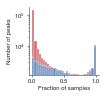

In [37]:
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
plt.hist([binary_counts.loc[binary_counts.index.isin(filtered_peaks)].sum(axis=1)/len(binary_counts.columns),
          binary_counts.loc[~binary_counts.index.isin(filtered_peaks)].sum(axis=1)/len(binary_counts.columns)],
         bins=30, stacked=True, alpha=ALPHA, color=[BLUE, RED], linewidth=CIRCLE_LINE_WIDTH)
ax.set_yscale('log')
ax.set_ylabel('Number of peaks')
ax.set_xlabel('Fraction of samples')
sns.despine()
if SAVE_FIG:
    utils.savefig(os.path.join(fig_dir, 'peak_sharing.svg'))